In [1]:
import numpy as np
from scipy.ndimage import rotate
from dggrid4py import DGGRIDv7
import tempfile
import shapely
import geopandas as gpd
from matplotlib import pyplot as plt

In [2]:
tmp = tempfile.TemporaryDirectory()
dggrid = DGGRIDv7('/home/dick/micromamba/envs/xdggs/bin/dggrid', working_dir=tmp.name, silent=True)

In [3]:
# to confirm the rotation is changing 19 from odd to even , -19 from even to odd 
#box = shapely.geometry.box(2542500., 1561500. ,6013500., 5417500)
#box = gpd.GeoSeries([box], crs='EPSG:3035').to_crs('wgs84')
#reg5 = dggrid.grid_cell_polygons_for_extent('IGEO7', 9, clip_geom=box.geometry.values[0], output_address_type='Z7_STRING')
#reg5['name']
#cellId = reg5['name'][0]
#reg6 = dggrid.grid_cell_polygons_from_cellids([cellId], 'IGEO7', 2, clip_subset_type='COARSE_CELLS', clip_cell_res=1, input_address_type='Z7_STRING', output_address_type='Z7_STRING')
#reg7 = dggrid.grid_cell_polygons_from_cellids([cellId], 'IGEO7', 3, clip_subset_type='COARSE_CELLS', clip_cell_res=1, input_address_type='Z7_STRING', output_address_type='Z7_STRING')
#from matplotlib import pyplot as plt
#fig, ax = plt.subplots(1,1,)
#reg7.plot(ax=ax,facecolor='none', edgecolor='red')
#reg6.plot(ax =ax, facecolor='none',edgecolor='blue')
#reg5[reg5['name'] == cellId].plot(ax=ax,facecolor='none')

In [4]:
directions = np.array([
           complex(0,0), # 0 
           complex(0.5,np.sqrt(3)/2), #1 
           complex(0.5,-np.sqrt(3)/2), #2
           complex(1,0), #3
           complex(-1,0), #4
           complex(-0.5,np.sqrt(3)/2), #5
           complex(-0.5,-np.sqrt(3)/2) #6 
        ])

In [5]:
# angele from CPI paper by Kevin 
angle = np.sqrt(3/28)
scale_down = 1/np.sqrt(7)
rotate_ccw19 = complex(np.cos(-angle), np.sin(-angle))
directions * ( scale_down * rotate_ccw19)

array([ 0.        +0.j        ,  0.28418807+0.24918724j,
        0.07370844-0.37070771j,  0.35789652-0.12152047j,
       -0.35789652+0.12152047j, -0.07370844+0.37070771j,
       -0.28418807-0.24918724j])

In [15]:
cell_ids = "42340315"
path = [directions[int(cell_ids[0])]]
for i, c in enumerate(cell_ids[1:],1):
    print(path[-1])
    scaled_rotated = directions[int(c)] * ((scale_down**i * rotate_ccw19) if (i%2!=0) else (scale_down**i))
    path += [path[-1]+scaled_rotated]
print(path[-1])

(-1+0j)
(-0.9262915561708075-0.37070771257882074j)
(-0.7834344133136647-0.37070771257882074j)
(-0.834562487368904-0.3533476452274048j)
(-0.834562487368904-0.3533476452274048j)
(-0.8272584767895841-0.35582765484903567j)
(-0.8258007508420622-0.35330279944441634j)
(-0.8260156442643047-0.3522220189412711j)


In [16]:
current_pos = path[-1]

In [17]:
neighbours = current_pos + directions[1:]*(scale_down**(len(cell_ids)-1) *  )

SyntaxError: invalid syntax (3659550058.py, line 1)

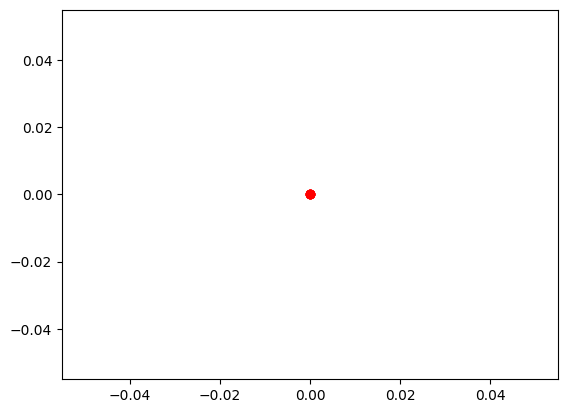

In [18]:
X = [x.real for x in neighbours]
Y = [x.imag for x in neighbours]
plt.scatter(X,Y, color='red')
plt.show()

In [19]:
def get_NN(neighbours, level, target=[]):
    rotation = rotate_ccw19 if (level%2==1) else 1
    # each neighbours's neighbours will contains original neighbours and the target
    # but it is not correct to exclude those "duplicated" neigbhours to reduce computation.
    # since it's neighbour may be the zero cell itself.
    exclude = target
    tmp_nn = np.repeat(neighbours,7).reshape(len(neighbours), -1)
    scaled_rotated_directions = directions*(scale_down**(level) * rotation)
    result = tmp_nn - scaled_rotated_directions
    idx,jdx = np.where(np.abs(result-exclude)<1e-9)
    result[idx,jdx]= np.inf
    result[:,0]=np.inf
    return result

In [20]:
nn = get_NN(neighbours, 8, [current_pos])
scaled_directions = directions * (scale_down**(len(cell_ids)-1) * rotate_ccw19)
all_zeros = path[-2] + 3  * scaled_directions

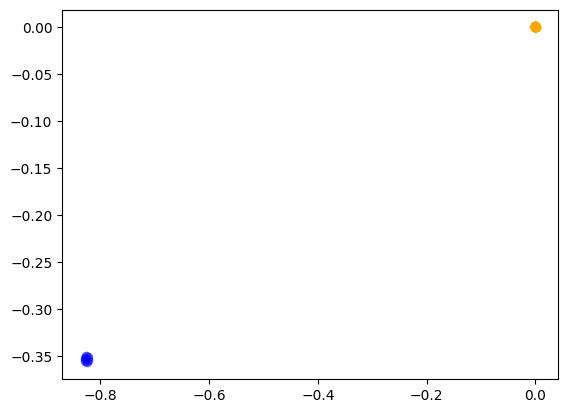

In [21]:
fig, ax = plt.subplots()
#X = [x.real for x in neighbours]
#Y = [x.imag for x in neighbours]
#ax.scatter(X,Y, color='red')
X1 = [i.real for i in nn.flatten() if (i != np.inf)]
Y1 = [i.imag for i in nn.flatten() if (i != np.inf)]
ax.scatter(X1,Y1, color='orange', alpha=0.5)
X2 = [i.real for i in all_zeros]
Y2 = [i.imag for i in all_zeros]
ax.scatter(X2,Y2, color='blue', alpha=0.5)

In [22]:
rotation = rotate_ccw19 if ((len(cell_ids)-1)%2==1) else 1
neighbours = current_pos + directions[1:]*(scale_down**(len(cell_ids)-1) *  rotation)

In [23]:
new_path = [0] + path
for p in new_path[-2::-1]:
    level = path.index(p)+1 if (p != 0) else 0
    p = new_path[0] if (p == 0) else p
    # parent's level roatation 
    rotation = rotate_ccw19 if ((level-1)%2==1 and (p != 0)) else 1
    # get the neighbour's neighbours at current level
    #print(f'{p} {level} {rotation} {(np.power(scale_down,level))}')
    nn = get_NN(neighbours, level, [current_pos])
    # get all near by zero cells location at parent's level, but with scaling at the current level 
    scaled_directions = directions * (np.power(scale_down,level) * rotation)
    # here we use the property that zero cells are 3 unit away from each other at 6 direction (center at any zero cell)
    # we center at the path intermediate 
    nearby_zeros = (p + 3  * scaled_directions).reshape(len(directions),1,1)
    # expand the dim to perform pair-wise distance between neighbour's neighbours and nearby zeros (7 direction)
    distance_matrix = np.abs(np.repeat(nn[np.newaxis, :, :], len(directions), axis=0) - nearby_zeros) / (np.power(scale_down,level))
    distance_matrix = np.min(distance_matrix, axis=0)
    # There are some cases that the distance to nearest zeros is 0.8 ~ 0.9 while all others are 1
    # However, the distance is not significant to be consider "closest", so the distance is clipped with 0.5 (1 unit between each pair of cell, so 0.5 )
    distance_matrix = np.where(1-distance_matrix<0.5,1,distance_matrix)
    #print(distance_matrix)
    # we choose the minimum distance (to the near by zero) as the direction where the neighbours come from.
    reverse_direction = np.argmin(distance_matrix,axis=-1)
    print(reverse_direction)
    # Prepare for next level. Move all neighbours to the neaest zero. Those will become the neighbours in next level up
    neighbours = neighbours - directions[reverse_direction] * (np.power(scale_down,level) * rotation)
    nearby_zeros= nearby_zeros.reshape(7,)
    neighbours = np.abs(np.repeat(neighbours[:, np.newaxis], len(directions), axis=-1) - nearby_zeros) / (np.power(scale_down,level))
    neighbours = np.where(neighbours<1)[1]
    #print(neighbours)
    neighbours = nearby_zeros[neighbours]

[6 0 1 2 3 4]
[4 1 1 2 2 1]
[3 0 0 0 0 0]
[0 0 0 0 0 0]
[4 4 4 4 4 4]
[3 3 3 3 3 3]
[2 2 2 2 2 2]
[4 4 4 4 4 4]


In [ ]:
fig, ax = plt.subplots()
X = [x.real for x in neighbours]
Y = [x.imag for x in neighbours]
ax.scatter(X,Y, color='red')
X1 = [i.real for i in nn.flatten() if (i != np.inf)]
Y1 = [i.imag for i in nn.flatten() if (i != np.inf)]
ax.scatter(X1,Y1, color='orange', alpha=0.5)
X2 = [i.real for i in nearby_zeros]
Y2 = [i.imag for i in nearby_zeros]
ax.scatter(X2,Y2, color='blue', alpha=0.5)

In [ ]:
parent_child = dggrid.grid_cell_polygons_from_cellids(['0042340315'], 'IGEO7', 9, clip_subset_type='COARSE_CELLS', clip_cell_res=8, input_address_type='Z7_STRING', output_address_type='Z7_STRING')

In [ ]:
parent_child.reset_index().plot(column='index',cmap='tab20')

In [ ]:
ax = parent_child.plot()
parent_child.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

In [ ]:
for k, v in nn.items():
        p = np.array([np.min(np.abs(i - nearby_zeros)) / (scale_down**(len(cell_ids)-1)) for i in v])
        p = np.where(1-p <1e-9,1,p)
        #print(p)
        if (len(np.unique(p)) == 1):
            # the neighbour itself is zero
            print(0)
        else:
            #print(np.argmin(p))
            print(len(directions) - (np.argmin(p)+1))            